In [1]:
# Import required libraries

!pip install pytorch-msssim
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import os
import torch
import helper
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision
from tqdm.notebook import tqdm
import torch.optim as optim

from PIL import Image 
from google.colab import drive
drive.mount('/content/drive')

data_path = './drive/MyDrive/images/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load test images, transform to Tensor and sample 1000 random 40x40 patches 

test_images = os.path.join(data_path, 'test_Waterloo')
img_list = sorted(os.listdir(test_images))

patch_size = 40
tensor_transform = torchvision.transforms.ToTensor()
random_crop = torchvision.transforms.RandomCrop(size = patch_size, pad_if_needed=False)

img_path_label = list()
for fp in img_list:
   full_fp = os.path.join(test_images, fp)
   img_path_label.append(full_fp)

concatenated_patches_list = []

for im in range(len(img_path_label)):
  for patch in range(int(round(1000/len(img_path_label),1))):
    img = Image.open(img_path_label[im])
    input = tensor_transform(img)
    input = random_crop(input).unsqueeze(0)
    concatenated_patches_list.append(input)

#len(concatenated_patches_list)

1000

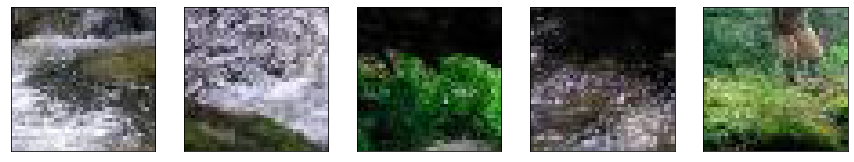

In [5]:
# Visualize some of the sampled patches

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
i = 0
ax[0].imshow(concatenated_patches_list[i].detach().cpu().squeeze().permute(1,2,0))
ax[1].imshow(concatenated_patches_list[i+1].detach().cpu().squeeze().permute(1,2,0))
ax[2].imshow(concatenated_patches_list[i+2].detach().cpu().squeeze().permute(1,2,0))
ax[3].imshow(concatenated_patches_list[i+3].detach().cpu().squeeze().permute(1,2,0))
ax[4].imshow(concatenated_patches_list[i+4].detach().cpu().squeeze().permute(1,2,0))

for axs in ax:
    axs.set_xticks([])
    axs.set_yticks([])

In [18]:
# Device and data type
device = 'cuda'
dtype = torch.float32

In [14]:
# Model class used for training

class Model(nn.Module):
    def __init__(self, dim):
        super(Model, self).__init__()

        self.num_feature_maps = 64
        self.filter_size = 3

        self.in_conv2d = nn.Conv2d(dim, self.num_feature_maps, self.filter_size, padding = 1)

        self.hid1 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 2, padding = 2)
        self.hid2 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 3, padding = 3)
        self.hid3 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 4, padding = 4)
        self.hid4 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 3, padding = 3)
        self.hid5 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 2, padding = 2)


        self.out_conv2d = nn.Conv2d(self.num_feature_maps, dim, self.filter_size, padding = 1)
        
        self.bn2d = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(p=0.0)
        self.h = nn.GELU()
        # self.h = nn.ReLU()

        
    def forward(self, img):
        out = self.dropout(self.h(self.in_conv2d(img)))

        out = self.dropout(self.h((self.hid1(out))))
        out = self.dropout(self.h((self.hid2(out))))
        out = self.dropout(self.h((self.hid3(out))))
        out = self.dropout(self.h((self.hid4(out))))
        out = self.dropout(self.h((self.hid5(out))))

        
        out = img-self.out_conv2d(out)

        return out

In [32]:
# Load pretrained model

checkpoint = torch.load('./drive/MyDrive/Plug and Play/denoiser_rgb_1.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [33]:
# Utilities

import math
# PSNR
def compute_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return (10 * torch.log10(torch.max(img1) / mse)).item()
# Mean
def mean(input_list):
  num = len(input_list)
  mean = (sum(input_list))/(num)
  return mean
# Standard Deviation
def std(input_list):
  num = len(input_list)
  mean = sum(input_list)/(num)
  deviations = [(x - mean) ** 2 for x in input_list]
  variance = sum(deviations) / (num-1)
  std = math.sqrt(variance)
  return std

In [34]:
# Test all patches and compute average PSNR, average SSIM, standard deviation of PSNR and standard deviation of SSIM

noise = 0.05
#noise = 0.2
concatenated_patches_list
model.eval()

psnr_values = []
ssim_values = []

for inp in concatenated_patches_list:
  #noisy_inp = inp + noise*torch.rand_like(inp) - noise/2
  noisy_inp = inp + noise*torch.randn_like(inp)
  noisy_inp = noisy_inp.to(device)
  inp = inp.to(device)
  with torch.no_grad():
     model_out = model(noisy_inp)
  psnr_values.append(compute_psnr(inp, model_out))
  ssim_values.append(ssim(inp, model_out, data_range=1.0).item())

average_psnr = mean(psnr_values)
average_ssim = mean(ssim_values)

std_psnr = std(psnr_values)
std_ssim = std(ssim_values)

print("The average PSNR value is: {}".format(round(average_psnr,3)))
print("The average SSIM value is: {}".format(round(average_ssim,3)))
print("The average standard deviation of the PSNR value is: {}".format(std_psnr))
print("The average standard deviation of the SSIM value is: {}".format(std_ssim))

#fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#ax[0].imshow(noisy_inp[0].detach().cpu().squeeze().permute(1,2,0),)
#ax[1].imshow(model_out[0].detach().cpu().squeeze().permute(1,2,0),)

The average PSNR value is: 29.304
The average SSIM value is: 0.812
The average standard deviation of the PSNR value is: 1.5679475737352302
The average standard deviation of the SSIM value is: 0.11860442808745954


In [12]:
# Save sampled patches for reproducibility

from torchvision.utils import save_image

for img in range(len(concatenated_patches_list)):
  save_image(concatenated_patches_list[img],'./drive/MyDrive/images/Test_Patches_Denoiser_Evaluation/patch' + str(img) + '.png')